# LGBM - Catboost Simone

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from catboost import CatBoostRegressor
import csv

%load_ext autoreload
%matplotlib inline

In [2]:
# import sklearn
# sklearn.metrics.SCORERS.keys()

## Import data and small preprocessing

In [4]:
trainData = pd.read_csv("train_preprocessed.csv",dtype={'Store': object,'ts_promo': object,'store_promo': object,'dom_promo': object,'dow_promo': object})
trainData['Date'] = pd.to_datetime(trainData['Date'])
trainData

,Date,ts_id,isPromo,Sales,Store,SKU,Segment,Pack,Product,Brand,...,Season,Birthdays,ts_promo,store_promo,segment_promo,brand_promo,sku_promo,dom_promo,dow_promo,Holiday
0,2015-06-15,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",150.0,00,Not Holiday
1,2015-06-16,0,0.0,0.050,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",160.0,11,Not Holiday
2,2015-06-17,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",170.0,22,Not Holiday
3,2015-06-18,0,0.0,0.200,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",180.0,33,Ramadan starts
4,2015-06-19,0,0.0,0.100,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",190.0,44,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382316,2017-06-10,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",100.0,55,Not Holiday
1382317,2017-06-11,2063,0.0,0.225,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",110.0,66,Not Holiday
1382318,2017-06-12,2063,0.0,0.315,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",120.0,00,Russia Day
1382319,2017-06-13,2063,0.0,0.585,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,spring,0.083396,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",130.0,11,Not Holiday


In [5]:
testData = pd.read_csv("test_preprocessed.csv",dtype={'Store': object,'ts_promo': object,'store_promo': object,'dom_promo': object,'dow_promo': object})
testData['Date'] = pd.to_datetime(testData['Date'])
testData

,id,Date,ts_id,isPromo,Store,SKU,Segment,Pack,Product,Brand,...,Season,Birthdays,ts_promo,store_promo,segment_promo,brand_promo,sku_promo,dom_promo,dow_promo,Holiday
0,0,2017-06-15,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",150.0,30.0,Not Holiday
1,1891,2017-06-16,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",160.0,40.0,Not Holiday
2,3782,2017-06-17,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",170.0,50.0,Not Holiday
3,5673,2017-06-18,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",180.0,60.0,Not Holiday
4,7564,2017-06-19,0,0.0,3301,"_Baltika №0 Can 0,45",Premium,Can,Non-alco,Baltika №3,...,spring,0.083396,00.0,33010.0,Premium0.0,Baltika №30.0,"_Baltika №0 Can 0,450.0",190.0,00.0,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192877,185317,2017-09-27,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",270.0,20.0,Not Holiday
192878,187208,2017-09-28,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",280.0,30.0,Not Holiday
192879,189099,2017-09-29,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",290.0,40.0,Not Holiday
192880,190990,2017-09-30,2063,0.0,Q096,"_Baltika №9 Can 0,45",MainStream,Can,Lager,Baltika №9,...,autumn,0.085779,20630.0,Q0960.0,MainStream0.0,Baltika №90.0,"_Baltika №9 Can 0,450.0",300.0,50.0,Not Holiday


In [6]:
for c in trainData.columns:
    col_type = trainData[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        trainData[c] = trainData[c].astype('category')

In [7]:
for c in testData.columns:
    col_type = testData[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        testData[c] = testData[c].astype('category')

In [8]:
print(trainData['Date'].is_monotonic_increasing)
print(testData['Date'].is_monotonic_increasing)
trainData = trainData.sort_values(by=['Date'])
testData = testData.sort_values(by=['Date'])

False
False


In [9]:
X = trainData.drop(['Sales','Date'], axis=1)#Date
y = trainData['Sales']

In [10]:
var_categ =[]
for c in X.columns:
    col_type = X[c].dtype
    if col_type.name == 'category':
        var_categ.append(c)
var_categ

['Store',
 'SKU',
 'Segment',
 'Pack',
 'Product',
 'Brand',
 'Season',
 'ts_promo',
 'store_promo',
 'segment_promo',
 'brand_promo',
 'sku_promo',
 'dom_promo',
 'dow_promo',
 'Holiday']

# LGBM

## Get best hyperparam

In [11]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# lgbm = LGBMRegressor(
#     silent=True, 
#     n_jobs=-1, 
#     #device = "gpu"
#     )

# search_space = {"boosting_type": Categorical(['dart']),
#         "num_leaves": Integer(6, 60), 
#         "max_depth": Integer(-1, 40), 
#         "learning_rate": Real(0.001,1),
#         "n_estimators": Integer(2, 1000),
#         "subsample_for_bin": Integer(195000, 204000),
#         "colsample_bytree" : Real (0.5,1.0),#New
#         "subsample": Real (0.5,1.0) #New
#     }
# cv = TimeSeriesSplit(n_splits=7)

# bayes_cv_tuner = BayesSearchCV(
#     estimator = lgbm, 
#     search_spaces =search_space, 
#     n_iter=20, # specify how many iterations
#     scoring="neg_root_mean_squared_error",
#     cv=cv,
#     verbose=0,
#     n_jobs =-1
# )

# def print_status(optimal_result):
#     """Shows the best parameters found and accuracy attained of the search so far."""
#     print("Done")

# bayes_cv_tuner.fit(X, y, callback=print_status) # .iloc[1:500]

In [12]:
# bayes_cv_tuner.best_params_

In [13]:
# print(type(bayes_cv_tuner.best_params_))

# keys, values = [], []
# for key, value in bayes_cv_tuner.best_params_.items():
#     keys.append(key)
#     values.append(value)       

# with open("LGBMBestParam.csv", "w") as outfile:
#     csvwriter = csv.writer(outfile)
#     csvwriter.writerow(keys)
#     csvwriter.writerow(values)

In [14]:
# bayes_cv_tuner.best_score_

In [15]:
# from skopt.plots import plot_convergence

# plot_convergence(result) 

## Apply

In [16]:
lgbm = LGBMRegressor(
    boosting_type = 'dart',
    learning_rate = 0.35878911553612336, 
    max_depth = 1,
    metric='rmse',
    n_estimators = 524,
    num_leaves = 21,
    subsample_for_bin = 199000,
    colsample_bytree = 0.8,
    subsample = 1.0,
    silent=True
    )
#BestParam
# [('boosting_type', 'dart'),#1
#              ('learning_rate', 0.039741509928932967),
#              ('max_depth', 10), #Max
#              ('n_estimators', 336),
#              ('num_leaves', 26),
#              ('subsample_for_bin', 201000)]) #Max

# [('boosting_type', 'dart'),#2
#              ('learning_rate', 0.4013806578117077),
#              ('max_depth', 14),
#              ('n_estimators', 113),
#              ('num_leaves', 8),
#              ('subsample_for_bin', 199119)])
# ([('boosting_type', 'dart'),#3 best
#              ('colsample_bytree', 0.8),
#              ('learning_rate', 0.35878911553612336),
#              ('max_depth', 1),
#              ('n_estimators', 524),
#              ('num_leaves', 21),
#              ('subsample', 1.0),
#              ('subsample_for_bin', 199000)])
# [('boosting_type', 'dart'), #4
#              ('colsample_bytree', 0.7423119611889375),
#              ('learning_rate', 0.7376761996696818),
#              ('max_depth', 1),
#              ('n_estimators', 61),
#              ('num_leaves', 7),
#              ('subsample', 0.6455963683564654),
#              ('subsample_for_bin', 204000)])

In [36]:
#TSCV
# tscv = TimeSeriesSplit(n_splits=7)
# rmse=[]
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     lgbm.fit(X_train,y_train)
#     lgbm_prediction = lgbm.predict(X_test)
#     rmse.append(round(mean_squared_error(lgbm_prediction, y_test,squared=False), 2))
    
# average_rmse = np.mean(rmse)
# print(average_rmse)

testX = testData.drop(['id','Date'], axis=1)
if 'Sales' in testX.columns:
    testX = testX.drop(['Sales'], axis=1)

#Now all data
lgbmfit = lgbm.fit(X,y)
lgbm_prediction = lgbm.predict(testX)

testData['Sales'] = lgbm_prediction
testData = testData.sort_values(by=['id'])
print(testData)
testData[['id','Sales']].to_csv("LGBMsubmission.csv", index=False)


            id       Date  ts_id  isPromo Store                      SKU  \
0            0 2017-06-15      0      0.0  3301     _Baltika №0 Can 0,45   
102          1 2017-06-15      1      1.0  3301     _Baltika №3 Can 0,45   
204          2 2017-06-15      2      1.0  3301     _Baltika №7 Can 0,45   
306          3 2017-06-15      3      1.0  3301  _Baltika №7 Bottle 0,47   
408          4 2017-06-15      4      0.0  3301     _Baltika №9 Can 0,45   
...        ...        ...    ...      ...   ...                      ...   
192473  192877 2017-10-01   2059      0.0  Q096      _Carlsberg Can 0,45   
192575  192878 2017-10-01   2060      1.0  Q096     _Baltika №0 Can 0,45   
192677  192879 2017-10-01   2061      0.0  Q096     _Baltika №3 Can 0,45   
192779  192880 2017-10-01   2062      1.0  Q096     _Baltika №7 Can 0,45   
192881  192881 2017-10-01   2063      0.0  Q096     _Baltika №9 Can 0,45   

           Segment    Pack   Product       Brand  ...  Birthdays  ts_promo  \
0        

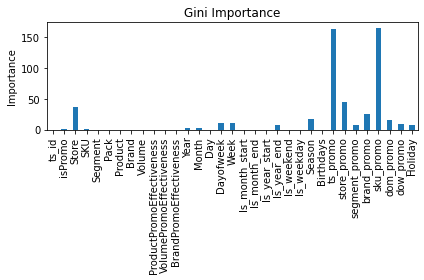

In [37]:
importances = lgbm.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

In [19]:
lgbm_prediction =testData['Sales']
lgbm_prediction

0         0.159840
102       0.773279
204       0.730544
306       0.471378
408       0.202666
            ...   
192473    0.249754
192575    0.158666
192677    0.162482
192779    0.609956
192881    0.145479
Name: Sales, Length: 192882, dtype: float64

# CatBoost

## Get best hyperparam

In [67]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
        
# catboost = CatBoostRegressor(
#     silent=True, 
#     #task_type = "GPU",
#     cat_features=var_categ
#     )

# search_space = {
#         'iterations': Integer(10, 800),
#     #CatBoostError: only one of the parameters iterations, n_estimators, num_boost_round, num_trees should be initialized.

#         #"n_estimators": Integer(6, 500), 
#         "learning_rate": Real(0.01,1),
#         'random_strength': Real(1e-9, 10, 'log-uniform'),
#         "depth": Integer(1, 10),
#         "bagging_temperature": Real(0.0, 1.0),
#         'border_count': Integer(1, 255),
#         'l2_leaf_reg': Integer(2, 30),               
#     }


# cv = TimeSeriesSplit(n_splits=7)

# bayes_cv_tuner = BayesSearchCV(
#     estimator = catboost, 
#     search_spaces =search_space, 
#     n_iter= 15, # specify how many iterations
#     scoring="neg_root_mean_squared_error",
#     cv=cv,
#     verbose=0,
#     n_jobs =-1
# )

# def print_status(optimal_result):
#     """Shows the best parameters found and accuracy attained of the search so far."""
#     print("DONE")
# #     models_tested = pd.DataFrame(bayes_cv_tuner.cv_results_)
# #     best_parameters_so_far = pd.Series(bayes_cv_tuner.best_params_)
# #     print(
# #         "Model #{}\nBest RMSE so far: {}\nBest parameters so far: {}\n".format(
# #             len(models_tested),
# #             np.round(bayes_cv_tuner.best_score_, 3),
# #             bayes_cv_tuner.best_params_,
# #         )
# #     )

# #     clf_type = bayes_cv_tuner.estimator.__class__.__name__
# #     models_tested.to_csv(clf_type + "_cv_results_summary.csv")

# bayes_cv_tuner.fit(X, y, callback=print_status)# .iloc[1:500]

In [68]:
# bayes_cv_tuner.best_params_

In [69]:
# print(type(bayes_cv_tuner.best_params_))

# keys, values = [], []
# for key, value in bayes_cv_tuner.best_params_.items():
#     keys.append(key)
#     values.append(value)       

# with open("CatboostBestParam.csv", "w") as outfile:
#     csvwriter = csv.writer(outfile)
#     csvwriter.writerow(keys)
#     csvwriter.writerow(values)

In [70]:
# bayes_cv_tuner.best_score_

## Apply

In [40]:
catboost = CatBoostRegressor(
    n_estimators=64,
    learning_rate=0.14038578250228806,
    depth=8,
    bagging_temperature=0.1075748346436656,
    border_count = 213,
    l2_leaf_reg = 12,
    random_strength = 5.03421359307061e-09,
    cat_features=var_categ,
    thread_count=-1,
    silent=True
)
#BestParam
# [('bagging_temperature', 0.42802269671472565), #1
#              ('border_count', 180),
#              ('depth', 2),
#              ('l2_leaf_reg', 13),
#              ('learning_rate', 0.09424480742594872),
#              ('n_estimators', 60),
#              ('random_strength', 9.029905504478138e-08)]

# ([('bagging_temperature', 0.9094652241987762), #2
#              ('border_count', 223),
#              ('depth', 1),
#              ('l2_leaf_reg', 4),
#              ('learning_rate', 0.01058603000501733),
#              ('n_estimators', 82),
#              ('random_strength', 1.272165412113495e-08)])

# [('bagging_temperature', 0.1075748346436656), #3 best
#              ('border_count', 213),
#              ('depth', 8),
#              ('l2_leaf_reg', 12),
#              ('learning_rate', 0.14038578250228806),
#              ('n_estimators', 64),
#              ('random_strength', 5.03421359307061e-09)])

# [('bagging_temperature', 1.0), #4
#              ('border_count', 112),
#              ('depth', 8),
#              ('l2_leaf_reg', 30),
#              ('learning_rate', 0.38487817448416656),
#              ('n_estimators', 6),
#              ('random_strength', 0.0004726359309565526)])
# [('bagging_temperature', 0.37166939185644426), #5
#              ('border_count', 255),
#              ('depth', 1),
#              ('iterations', 285),
#              ('l2_leaf_reg', 19),
#              ('learning_rate', 0.01),
#              ('random_strength', 10.0)])

In [41]:
#TSCV
# tscv = TimeSeriesSplit(n_splits=7)#4 months each
# rmse=[]
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     catboost.fit(X_train,y_train)
#     catboost_prediction = catboost.predict(X_test)
#     rmse.append(round(mean_squared_error(catboost_prediction, y_test,squared=False), 2))
    
# average_rmse = np.mean(rmse)
# print(average_rmse)

testX = testData.drop(['id','Date'], axis=1)
if 'Sales' in testX.columns:
    testX = testX.drop(['Sales'], axis=1)

#Now all data
catboost.fit(X,y)
catboost_prediction = catboost.predict(testX)
print(catboost_prediction)
testData['Sales'] = catboost_prediction
testData = testData.sort_values(by=['id'])
print(testData)
testData[['id','Sales']].to_csv("catboostSubmission.csv", index=False)


[0.10093112 0.51204787 0.81992092 ... 0.17014222 0.57963474 0.23293307]
            id       Date  ts_id  isPromo Store                      SKU  \
0            0 2017-06-15      0      0.0  3301     _Baltika №0 Can 0,45   
102          1 2017-06-15      1      1.0  3301     _Baltika №3 Can 0,45   
204          2 2017-06-15      2      1.0  3301     _Baltika №7 Can 0,45   
306          3 2017-06-15      3      1.0  3301  _Baltika №7 Bottle 0,47   
408          4 2017-06-15      4      0.0  3301     _Baltika №9 Can 0,45   
...        ...        ...    ...      ...   ...                      ...   
192473  192877 2017-10-01   2059      0.0  Q096      _Carlsberg Can 0,45   
192575  192878 2017-10-01   2060      1.0  Q096     _Baltika №0 Can 0,45   
192677  192879 2017-10-01   2061      0.0  Q096     _Baltika №3 Can 0,45   
192779  192880 2017-10-01   2062      1.0  Q096     _Baltika №7 Can 0,45   
192881  192881 2017-10-01   2063      0.0  Q096     _Baltika №9 Can 0,45   

           Segm

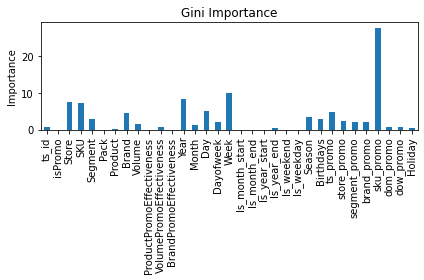

In [42]:
importances = catboost.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

In [74]:
# Stacking different algorithm, different input (only the prediction, Test+Sales), different hyperparam
#LGBM,Linear Reg, XGBoost
#For each try with only prediction input and different hyperapram, with test+sales and automize bestg hyperparam

## AVG

In [85]:
lgbm_prediction.to_numpy()
print(lgbm_prediction)
avg_prediction = np.mean([lgbm_prediction, catboost_prediction], axis=0)
testData['Sales'] = avg_prediction
testData = testData.sort_values(by=['id'])
testData[['id','Sales']].to_csv("avg.csv", index=False)
testData[['id','Sales']]

## Try averaging all

In [76]:
# catboost1 = CatBoostRegressor(
#     n_estimators=60,
#     learning_rate=0.09424480742594872,
#     depth=2,
#     bagging_temperature=0.42802269671472565,
#     border_count = 180,
#     l2_leaf_reg = 13,
#     random_strength = 9.029905504478138e-08,
#     cat_features=var_categ,
#     thread_count=-1,
#     silent=True
# )

# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# catboost1.fit(X,y)
# catboost1_prediction = catboost1.predict(testX)
# print(catboost1_prediction)
# testData['Sales'] = catboost1_prediction
# testData = testData.sort_values(by=['id'])

# catboost2 = CatBoostRegressor(
#     n_estimators=82,
#     learning_rate=0.01058603000501733,
#     depth=1,
#     bagging_temperature=0.9094652241987762,
#     border_count = 223,
#     l2_leaf_reg = 4,
#     random_strength = 1.272165412113495e-08,
#     cat_features=var_categ,
#     thread_count=-1,
#     silent=True
# )

# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# catboost2.fit(X,y)
# catboost2_prediction = catboost2.predict(testX)
# print(catboost2_prediction)
# testData['Sales'] = catboost2_prediction
# testData = testData.sort_values(by=['id'])

# catboost4 = CatBoostRegressor(
#     n_estimators=6,
#     learning_rate=0.38487817448416656,
#     depth=8,
#     bagging_temperature=1.0,
#     border_count = 112,
#     l2_leaf_reg = 30,
#     random_strength = 0.0004726359309565526,
#     cat_features=var_categ,
#     thread_count=-1,
#     silent=True
# )

# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# catboost4.fit(X,y)
# catboost4_prediction = catboost4.predict(testX)
# print(catboost4_prediction)
# testData['Sales'] = catboost4_prediction
# testData = testData.sort_values(by=['id'])

# catboost5 = CatBoostRegressor(
#     iterations=285,
#     learning_rate=0.01,
#     depth=1,
#     bagging_temperature=0.37166939185644426,
#     border_count = 255,
#     l2_leaf_reg = 19,
#     random_strength = 10.0,
#     cat_features=var_categ,
#     thread_count=-1,
#     silent=True
# )

# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# catboost5.fit(X,y)
# catboost5_prediction = catboost5.predict(testX)
# print(catboost5_prediction)
# testData['Sales'] = catboost5_prediction
# testData = testData.sort_values(by=['id'])


In [77]:
# lgbm1 = LGBMRegressor(
#     boosting_type = 'dart',
#     learning_rate = 0.039741509928932967, 
#     max_depth = 1,
#     metric='rmse',
#     n_estimators = 336,
#     num_leaves = 26,
#     subsample_for_bin = 201000,
#     silent=True
#     )
# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# lgbm1.fit(X,y)
# lgbm1_prediction = lgbm1.predict(testX)

# testData['Sales'] = lgbm1_prediction
# testData = testData.sort_values(by=['id'])
# print(lgbm1_prediction)


# lgbm2 = LGBMRegressor(
#     boosting_type = 'dart',
#     learning_rate = 0.4013806578117077, 
#     max_depth = 14,
#     metric='rmse',
#     n_estimators = 113,
#     num_leaves = 8,
#     subsample_for_bin = 199119,
#     silent=True
#     )
# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# lgbm2.fit(X,y)
# lgbm2_prediction = lgbm2.predict(testX)

# testData['Sales'] = lgbm2_prediction
# testData = testData.sort_values(by=['id'])
# print(lgbm2_prediction)


# lgbm4 = LGBMRegressor(
#     boosting_type = 'dart',
#     learning_rate = 0.4013806578117077, 
#     max_depth = 1,
#     metric='rmse',
#     n_estimators = 61,
#     num_leaves = 7,
#     subsample_for_bin = 204000,
#     colsample_bytree = 0.7423119611889375,
#     subsample = 0.6455963683564654,
#     silent=True
#     )
# testX = testData.drop(['id','Date'], axis=1)
# if 'Sales' in testX.columns:
#     testX = testX.drop(['Sales'], axis=1)

# #Now all data
# lgbm4.fit(X,y)
# lgbm4_prediction = lgbm4.predict(testX)

# testData['Sales'] = lgbm4_prediction
# testData = testData.sort_values(by=['id'])
# print(lgbm4_prediction)



In [78]:
# lgbm_prediction.to_numpy()
# print(lgbm_prediction)

# weights = np.array([0.48003,0.47373,0.47310,0.47730,0.47472,0.52458,0.46633,0.48150,0.49091])
# print(type(weights))
# avg_prediction = np.average(
#     [lgbm1_prediction,
#      lgbm2_prediction,
#      lgbm_prediction,
#      lgbm4_prediction,
#      catboost1_prediction,
#      catboost2_prediction,
#      catboost_prediction,
#      catboost4_prediction,
#      catboost5_prediction,
     
#     ],
#     weights = 1 / weights ** 4,
#     axis=0
# )
# testData['Sales'] = avg_prediction
# testData = testData.sort_values(by=['id'])
# testData[['id','Sales']].to_csv("avgAll.csv", index=False)